# Lesson 3: Fades and Playback with PyAudio

We paused in Lesson 2 after discussing **fade-in** and **fade-out**.
This lesson picks up there and adds **playing audio with PyAudio**.

You will:
- Generate or load a simple waveform
- Apply fade-in and fade-out envelopes
- Visualise the fades and mixes
- Inspect levels (including RMS) and normalise
- Play audio with a reusable PyAudio helper


## 1. Setup

Run this cell once to import the modules we need.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

print("NumPy version:", np.__version__)
print("PyAudio version:", getattr(pyaudio, '__version__', 'unknown'))


NumPy version: 2.0.2
PyAudio version: 0.2.14


## 2. Get or generate a waveform

If you still have `example_tone.wav` from Lesson 2, you can load it here.
Otherwise, generate a 1-second sine tone at 440 Hz (16 kHz, 16-bit mono).

### Task
- Set `sr = 16000` and `duration = 1.0`.
- Either **load** `example_tone.wav` as an `int16` NumPy array called
  `waveform`, or **generate** it with `np.sin` (scale to 16-bit PCM: multiply
  by 32767 and cast to `np.int16`).
- Create a time axis `t` matching the length of `waveform`.
- Plot a short segment of the waveform to confirm it looks reasonable.


In [55]:
import numpy as np
import wave
import matplotlib.pyplot as plt

sr = 16000
duration = 1.
freq = 440.0
num_samples = int(sr * duration)

# TODO: load example_tone.wav if present, otherwise generate a sine tone.
# TODO: create `t` to match `waveform`.
# TODO: plot a short segment (e.g., first 1000 samples) to inspect it.

t = np.linspace(0, duration, int(sr * duration))
x = np.sin(2 * np.pi * freq * t)
scale = 2 ** 15

waveform = (x * scale).astype(np.int16)


## 3. PyAudio playback helper

We will use a single helper function `play_audio(array, sr)`
to play any waveform we create. This keeps playback code short in later
sections.


In [56]:
x.shape

(16000,)

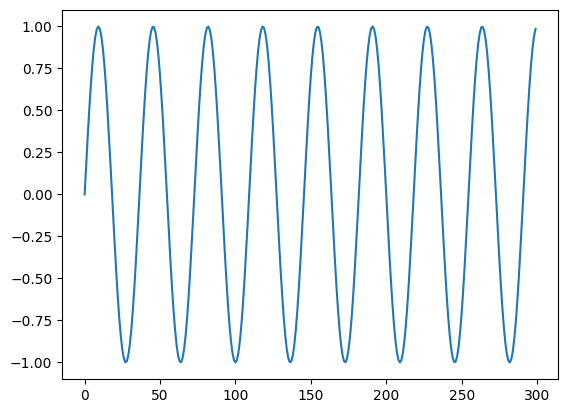

In [59]:
plt.plot(x[:300])

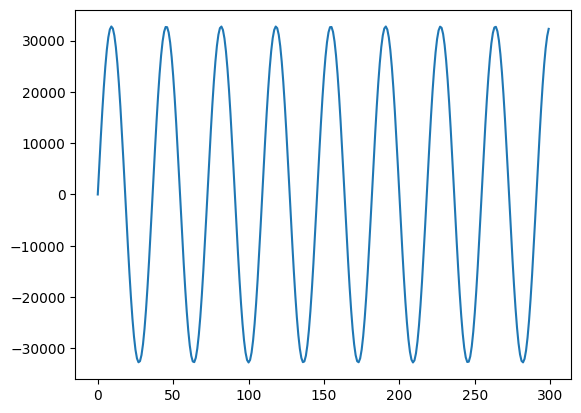

In [60]:
plt.plot(waveform[:300])

In [65]:
import pyaudio

def play_audio(arr, sr=16000):
    pa = pyaudio.PyAudio()
    stream = pa.open(
        format=pyaudio.paInt16,
        channels=1,
        rate=sr,
        output=True
    )
    
    stream.write(arr.tobytes())

    stream.stop_stream()
    stream.close()
    pa.terminate()

play_audio(waveform)


## 4. Recording helper (optional)

A small helper to record a short clip with PyAudio. It returns a
NumPy int16 array and the sample rate.

### Instruction
- Review the helper `record_audio(seconds, sr)` below.
- You can call it to capture a brief clip, plot it, and play it back
  with `play_audio`.


In [ ]:
import pyaudio
import numpy as np

def record_audio(seconds=2, sr=16000):
    pa = pyaudio.PyAudio()
    stream = pa.open(
        format=pyaudio.paInt16,
        channels=1,
        rate=sr,
        input=True
    )
    
    num_frames = int(sr * seconds)
    data = stream.read(num_frames)
    stream.stop_stream(); stream.close(); pa.terminate()
    return np.frombuffer(data, dtype=np.int16), sr

wv = record_audio()


ALSA lib pcm_dsnoop.c:567:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:404:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:404:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_a52.c:1036:(_snd_pcm_a52_open) a52 is only for playback
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:481:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:481:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) unable to open slave


In [39]:
play_audio(wv[0])

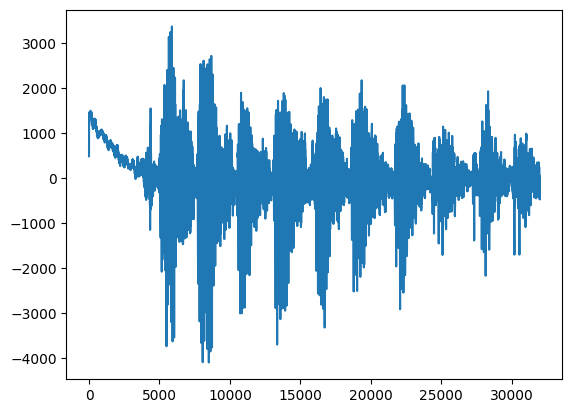

In [33]:
plt.plot(wv[0])

## 5. Creating fade-in and fade-out

A **fade-in** gradually increases volume from silence to full level.
A **fade-out** does the opposite.

### Task
- Starting from `waveform`:
  - Create a fade-in envelope `fade_in` going from 0.0 to 1.0.
  - Create a fade-out envelope `fade_out` going from 1.0 to 0.0.
  - Multiply `waveform` by these envelopes (after converting to float)
    to create `wave_in` and `wave_out`.
- Convert the results back to `int16`.
- Inspect the first and last few samples of `wave_in` and `wave_out`.


In [ ]:
# Fade in

# waveform[0] * 0.00
# waveform[1] * 0.01
# waveform[2] * 0.02
# waveform[3] * 0.03
# ...

In [67]:
waveform.shape

(16000,)

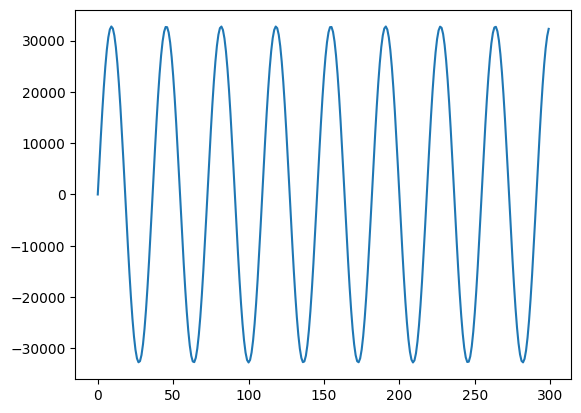

In [70]:
plt.plot(waveform[:300])

In [96]:
waveform[:10] * waveform_fadein[20:30]

array([     0,   6358, -29972, -10484,  22504,   8266,  -8562, -20273,
       -29256,   3556], dtype=int16)

In [101]:
scale.shape, waveform_fadein.shape

((100,), (16000,))

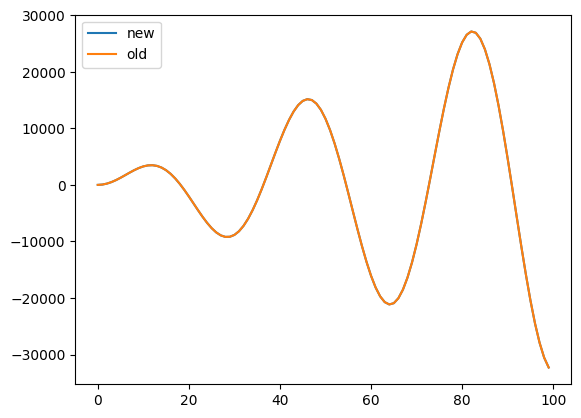

In [110]:
waveform_fadein = waveform.copy()


#scale = [i / 100 for i in range(100)]
scale = np.linspace(0, 1, 100)
# print(scale)

# for i in range(100):
#    waveform_fadein[i] = waveform_fadein[i] * scale[i]

plt.plot(waveform_fadein[:100] * scale, label="new")

waveform_fadein[:100] = scale * waveform_fadein[:100]

plt.plot(waveform_fadein[:100], label="old")
plt.legend()

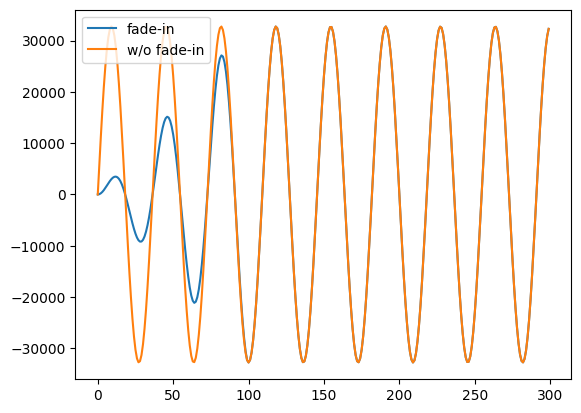

In [111]:
plt.plot(waveform_fadein[:300], label="fade-in")
plt.plot(waveform[:300], label="w/o fade-in")
plt.legend()

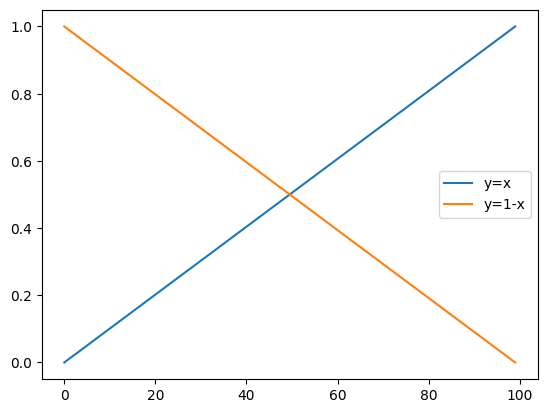

In [125]:
plt.plot(scale, label="y=x")
plt.plot(1 - scale, label="y=1-x")
plt.legend()
# y = x
# y = -x + 1 = 1 - x

In [124]:
scale_fadeout = 1 - scale

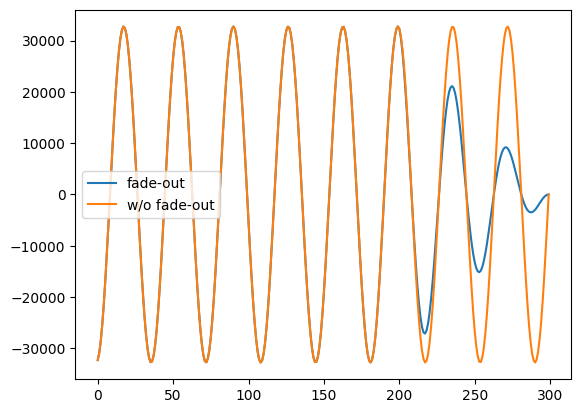

In [127]:
waveform_fadeout = waveform.copy()
waveform_fadeout[-100:] = scale_fadeout * waveform_fadeout[-100:]

plt.plot(waveform_fadeout[-300:], label="fade-out")
plt.plot(waveform[-300:], label="w/o fade-out")
plt.legend()

In [ ]:
import numpy as np

# TODO: create fade_in and fade_out with np.linspace of length len(waveform).
# TODO: create wave_in and wave_out by applying the fades (use float for multiplication, then back to int16).
# TODO: print a few samples from the start of wave_in and end of wave_out.
# TODO (optional): play_audio(wave_in, sr) or play_audio(wave_out, sr)


## 6. Visualising fade-in and fade-out

The fade-in should start near zero and grow; the fade-out should start
strong and decay to zero.

### Task
- Plot the first part of `wave_in` and `wave_out` to see the beginning
  of the fades.
- Plot the last part of `wave_in` and `wave_out` to see how they end.


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # TODO: choose N (e.g., 1000 or less if shorter).
# # TODO: plot wave_in[:N] and wave_out[:N] (start of fades).
# # TODO: plot wave_in[-N:] and wave_out[-N:] (end of fades).


## 7. Mixing two tones (optional)

To mix two sounds, you can **add their sample values** together.
Here we will create two tones with different frequencies and mix them
into a simple chord.


In [ ]:
import numpy as np

# TODO (optional): create a second tone `waveform_high` by reusing your
#       sine-wave code with a different frequency (e.g. 660 Hz).
# TODO: create a mixed signal by adding waveform and waveform_high.
#       Use np.clip to avoid overflow and convert the result to int16.
# TODO (optional): play_audio(mix, sr)


## 8. Visualising the mix (optional)

When two tones are mixed, the combined waveform is the sum of the
individual waveforms.

### Task
- Plot a short segment of `waveform` and `waveform_high` on the same
  axes.
- Plot the same segment of the mixed signal `mix` and compare its shape
  with the individual components.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: choose a short segment length, e.g. num_to_plot = min(1000, len(waveform)).
# TODO: plot waveform and waveform_high for that segment.
# TODO: plot the same segment of `mix`.


## 9. Inspecting levels and normalising (optional)

RMS (root mean square) measures the **average power** of a signal. It is
useful for comparing perceived loudness and for checking whether a signal
is too quiet or too loud before normalising.

### Task
- Compute and print the minimum, maximum and mean of `waveform`.
- Convert `waveform` to float in the range [-1, 1] called `x_float`.
- Compute the RMS (root mean square) of `x_float`.
- Create a normalised version `wave_norm` where the maximum absolute
  value is 32767 when converted back to int16.
- (Optional) play the normalised version with `play_audio`.


In [ ]:
import numpy as np

# TODO (optional): compute min, max, mean of `waveform`.
# TODO: x_float = waveform.astype(np.float32) / 32767.0
# TODO: compute RMS of x_float.
# TODO: create wave_norm by normalising to max abs 32767 (int16).
# TODO (optional): play_audio(wave_norm, sr)


## 10. Crossfading between two tones

A **crossfade** smoothly transitions from one signal to another, avoiding clicks.

### Task
- Create two tones (for example 440 Hz and 660 Hz) of equal length.
- Choose a crossfade length (e.g., 1000 samples).
- Build fade-out for tone A and fade-in for tone B over that window.
- Concatenate: tone A minus its last fade window + crossfaded window + tone B minus its first fade window.
- Plot the transition region to see the smooth change.
- (Optional) play the crossfaded result with `play_audio`.


In [ ]:
# A -> A[-100:] fade out
# B -> B[:100] fade in

# A[:-100] concat "crossfading" concat B[100:]

# crossfading = (A[-100:] fadeout) + (B[:100] fade in)

In [ ]:
freq = 440

array([     0,   5634,  11100, ..., -11100,  -5634,      0], dtype=int16)

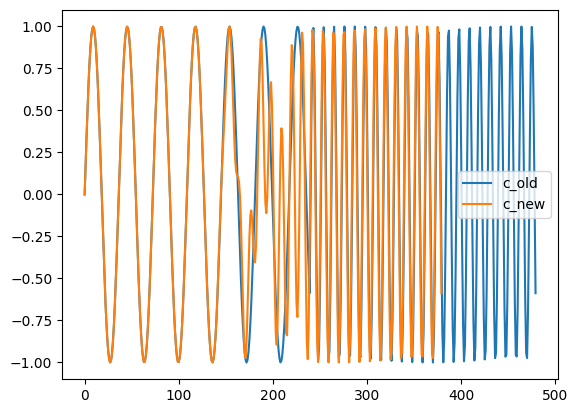

In [148]:
# TODO: generate two tones (e.g., 440 Hz and 660 Hz) of equal length.

duration = 0.015
t = np.linspace(0, duration, int(sr * duration))

freqa = 440
a = np.sin(2 * np.pi * freqa * t)

freqb = 1440
b = np.sin(2 * np.pi * freqb * t)


# A -> A[-100:] fade out
# B -> B[:100] fade in

# A[:-100] concat "crossfading" concat B[100:]

# crossfading = (A[-100:] fadeout) + (B[:100] fade in)
c_old = np.concatenate([a, b])

# crossfading = (A[-100:] fadeout) + (B[:100] fade in)
crossfading = a[-100:] * scale_fadeout + b[:100] * scale
c = np.concatenate([a[:-100], crossfading, b[100:]])

# plt.plot(a, label="a")
# plt.plot(b, label="b")
plt.plot(c_old, label="c_old")
plt.plot(c, label="c_new")
plt.legend()


# TODO: choose a crossfade length (e.g., 1000 samples).
# TODO: build fade-out for tone A and fade-in for tone B over that window.
# TODO: construct the crossfaded signal: A (minus last fade window) + crossfaded window + B (minus first fade window).
# TODO: plot the transition region to verify smooth change.
# TODO (optional): play the crossfaded result using play_audio.


## 11. Simple tremolo (amplitude modulation) (optional)

Tremolo is a periodic change in volume. You can create it by multiplying
the waveform by a slow low-frequency oscillator (LFO).

### Task (optional)
- Choose an LFO frequency (e.g., 5 Hz).
- Create an LFO array between 0 and 1 using `np.sin`.
- Multiply your waveform by the LFO (in float) and convert back to int16.
- Plot a short segment of the tremolo signal and compare to the original.
- (Optional) play the tremolo version with `play_audio`.


In [ ]:
# TODO: choose an LFO frequency (e.g., 5 Hz).
# TODO: create an LFO between 0 and 1 using np.sin over the waveform length.
# TODO: apply the LFO to your waveform (convert to float, multiply, then back to int16).
# TODO: plot a short segment of the tremolo signal vs. the original.
# TODO (optional): play the tremolo signal with play_audio.


## 12. PyAudio practice (optional)

Why write audio in **chunks** instead of all at once?
- Lower memory use: you don't need the whole signal in RAM.
- Lower latency: you can start playback sooner and stream data.
- This is how real-time systems work (continuous small buffers).

### Task (optional)
- Change the chunk size: instead of writing the whole waveform at once,
  write it in pieces (e.g., blocks of 1024 samples converted to bytes).
- Play a sequence of tones by concatenating several waveforms before writing,
  or by writing them one after another to the stream.
- Observe whether changing chunk size affects playback on your machine.


In [ ]:
import numpy as np
import pyaudio

# Example: play the mix (if available) in chunks

def play_in_chunks(arr, sr, chunk_size=1024):
    pa = pyaudio.PyAudio()
    stream = pa.open(format=pyaudio.paInt16, channels=1, rate=sr, output=True)
    for start in range(0, len(arr), chunk_size):
        stream.write(arr[start:start+chunk_size].tobytes())
    stream.stop_stream(); stream.close(); pa.terminate()

# If you created `mix`, uncomment to try chunked playback
# play_in_chunks(mix, sr)
